# **Soni - do:  Generating Music with Artificial Intelligence**


#### Author: Sonia Cobo
#### Date: July 2021

<table align="center"> 
<tr><td width="800"><img src="../resources/title.jpeg" style="width:10;height:10"></td>  
</table>

### Music is associated with emotions, experiences and creativity, all o them considered human's qualities. 

### Though this project doesn't have a hypothesis per se it was done to prove that technology has advanced to the point where a machine, that cannot experience these feelings, can generate music.

### This project will explain and show how music has been generated using a differente types of neural networks in Python. For this, different types of neural networks are two Long short-term memory (LSTM) models (a Bidirectional and a Unidirectional network) and a Generative adversarial network (GAN) considering different layers and parameters.

# Data

### Music files have been imported to Python in MIDI format. MIDI (Musical Instrument Digital Interface) is a technical standard that describes a communications protocol, digital interface, and electrical connectors that connect a wide variety of electronic musical instruments and computers. They don't contain actual audio data and are small in size. They explain what notes are played, when they're played, and how long or loud each note should be.

### To optimise results only MIDI files consisting of a single instrument were chosen. In this case, the chosen instrument is piano and the type of songs is classical. 

### These songs have been obtained from the following datasets: http://www.piano-midi.de/ and https://www.mfiles.co.uk/classical-midi.htm
### As guidance for the project the following example was considered: 'How to Generate Music using a LSTM Neural Network in Keras' by Sigurður Skúli.


## Import all libraries

In [91]:
# data manipulation
import numpy as np
import pandas as pd 
from collections import Counter


# manipulate midi files
import glob
from music21 import *
import pygame

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# route files
import os
import sys

# ml model
import pickle

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation

# my libraries
import utils.mining_data_tb as md
from utils.folders_tb import read_json
import utils.visualization_tb as vis
import utils.models as m
import utils.apis_tb as a

import warnings
warnings.filterwarnings("ignore")


## Paths

In [92]:
sep = os.sep
# path to raw data
path = md.route(1) + sep + "data" + sep + "raw_data" + sep
# path to data in the right key
path_1 = md.route(1) + sep + "data" + sep + "converted_data" + sep
# path to compiled notes list
path_2 = md.route(1) + sep + "data" + sep + "notes" + sep
# path to generated models
path_3 = md.route(1) + sep + "models" + sep
# path to generated midi files
path_4 = md.route(1) + sep + "reports" + sep
# path to output information
path_5 = md.route(1) + sep + "data" + sep + "output" + sep
# path to other songs
path_6 = md.route(1) + sep + "data" + sep + "more_inst_data" + sep


## Midi file exploration

### The Python library 'Music21' has been used to read and manipulate MIDI files. This library has the necessary classes to allow us to read music. 

### To start working with MIDI files these need to be converted to Score objects, which are a subclass for handling multi-part music. Once this is done it is possible to use the library build-in classes to view the file information. Knowing all the file components it is possible to select the useful ones for our prediction. The main components to generate new melodies, and those considered in this project, are notes, rests and chords. To make prediccions more accurate more components could be considered, such us the time signature or offsets.

### Note objects contain information about the pitch, octave, and offset of the note. Pitch refers to the frequency of the sound, or how high or low it is and is represented with the letters [A, B, C, D, E, F, G] or [Do, Re, Mi, Fa, Sol, La, Si] in Spanish. Octave refers to which set of pitches you use on a piano. Offset refers to where the note is located in the piece.

### Rests are the silences in the piece.

### Chord objects are a set of notes that are played at the same time.

### The below figure represents pitches and octaves in a keyboard for reference.

<table align="center"> 
<tr><td width="10000"><img src="../resources/pitch_and_octaves.png" style="width:14000;height:1500"></td>  
</table>

In [5]:
# All information from the midi file (i.e. notes, pitch, chord, time signature, etc) is contained within the component list

components = md.info_midi(path, "alb_esp1.mid")
components[:15]

[<music21.stream.Part 0x1d3b73d9148>,
 <music21.instrument.Piano 'Piano right: Piano right'>,
 <music21.instrument.Piano 'Piano'>,
 <music21.tempo.MetronomeMark moderate Quarter=93.43>,
 <music21.key.Key of F major>,
 <music21.meter.TimeSignature 3/4>,
 <music21.stream.Voice 0x1d3b7429148>,
 <music21.note.Rest rest>,
 <music21.note.Note A>,
 <music21.note.Note E>,
 <music21.note.Note D>,
 <music21.note.Note D>,
 <music21.note.Note C>,
 <music21.note.Note D>,
 <music21.note.Note E>]

### The component list also shows the piece key, which is the group of pitches, or scale, that forms the basis of a music composition. Each piece has its own key signature but using the same, in this case C major / A minor assists the model to not go off key. The below function read each piece key and transpose it to C major / A minor.

### ```All files have already been transposed so the below cell doesn't need to be executed again. It is a long process.```


In [128]:
# md.transpose_key(path, path_1)

In [ ]:
#  probar que pasa si le meto cualquier midi, de varios instrumentos, etc
# data augmentation = min_notes_freq

## EDA

### It is now understood all information provided by the MIDI file. This relevant information needs now to be encoded and saved into an array to feed the neural network. This project will only considered the notes (which relates to pitches), rests and chords.

### The pitch of every note object is appended to a list using string notation since the most significant parts of the note can be recreated using the string notation of the pitch. Chords are enconded using the id of every note together into a single string, with each note being separated by a dot.

In [6]:
# Each midi file contains notes, rests and chords. These three properties will be the input and output of the LSTM network so 
# they need to be taken out from all midi files.

one_song = md.get_notes_per_song(path_1, "C_alb_esp1.mid", path_2, "one_notes")

print(f" This list contains a total number of {len(one_song)} notes and chords, being {len(set(one_song))} of them unique.")

 This list contains a total number of 687 notes and chords, being 50 of them unique.


### It is possible to encode a list of songs at the same time rather than going one song at a time:

In [7]:
all_notes = md.get_all_notes(path = path_1, save_path = path_2, save_name = "all_notes")

print(f" This list contains a total number of {len(all_notes)} notes and chords, being {len(set(all_notes))} unique.")

 This list contains a total number of 696938 notes and chords, being 604 unique.


In [ ]:
# mirar memoria primero, a lo mejor voy a tener que quitar canciones

#pitchnames = sorted(set(all_notes)

### To avoid having to read and save all pieces each time the below function returns the previously coded and saved list containing the extracted notes from the pieces.

### The model will be first trained with a small proportion of the pieces to expedite time. Once the model is tunned properly all pieces will be passed to improve its predictions.

In [8]:
# Load notes and chords previously separated

#load_chopin = md.load_notes(path_2, "notes_chopin")
one_song = md.load_notes(path_2, "one_notes")

### To be able to share the input data a dataframe with all pieces and their notes has been created.

In [9]:
# generate dataframe

df_music = md.create_dataframe(path= path_1, save_path = path_2, save_name = "all_notes")

In [10]:
df_music

,Piece,Notes
0,C_alb_esp1,"[REST, E5, B5, A5, A5, G5, A5, B5, C6, D6, B5,..."
1,C_alb_esp2,"[REST, G3, 0.4.7, REST, G3, 0.4.7, 7.0, E4, F4..."
2,C_alb_esp3,"[E5, REST, G#5, REST, B5, REST, A5, A5, F5, RE..."
3,C_alb_esp4,"[A5, REST, E5, REST, F5, REST, A5, REST, G#5, ..."
4,C_alb_esp5,"[REST, 0.4, 11.2, 2.5, 11.2, 0.4, 9.0, 5.9, 4...."
...,...,...
337,C_waldstein_1,"[REST, 0.4, REST, 0.4, REST, 0.4, REST, 0.4, R..."
338,C_waldstein_2,"[REST, C3, REST, A3, REST, A3, A3, REST, 4.8, ..."
339,C_waldstein_3,"[REST, A5, G5, A5, G5, A5, G5, A5, G5, A5, G5,..."
340,C_waltz-op18-grande-brillante,"[D5, D5, REST, D5, REST, D5, D5, REST, D5, RES..."


### To avoid having to create and load the dataframe each time, it can be saved and read it back for its simple use.

In [95]:
md.save_dataframe(path_5, df_music, "df_music")

'Your file has been saved'

In [181]:
md.read_dataframe(path_5, "df_music")

,Piece,Notes
0,C_alb_esp1,"['REST', 'E5', 'B5', 'A5', 'A5', 'G5', 'A5', '..."
1,C_alb_esp2,"['REST', 'G3', '0.4.7', 'REST', 'G3', '0.4.7',..."
2,C_alb_esp3,"['E5', 'REST', 'G#5', 'REST', 'B5', 'REST', 'A..."
3,C_alb_esp4,"['A5', 'REST', 'E5', 'REST', 'F5', 'REST', 'A5..."
4,C_alb_esp5,"['REST', '0.4', '11.2', '2.5', '11.2', '0.4', ..."
...,...,...
337,C_waldstein_1,"['REST', '0.4', 'REST', '0.4', 'REST', '0.4', ..."
338,C_waldstein_2,"['REST', 'C3', 'REST', 'A3', 'REST', 'A3', 'A3..."
339,C_waldstein_3,"['REST', 'A5', 'G5', 'A5', 'G5', 'A5', 'G5', '..."
340,C_waltz-op18-grande-brillante,"['D5', 'D5', 'REST', 'D5', 'REST', 'D5', 'D5',..."


## Visualization

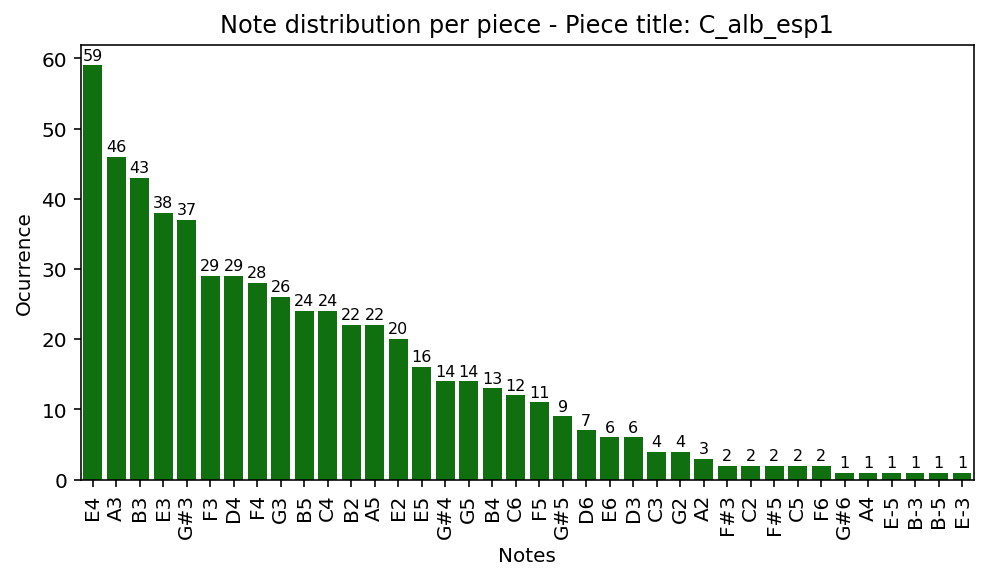

In [ ]:
vis.plot_one_song(df_music["Notes"], df_music["Piece"], 0)

### It is also possible to compare the note distribution considering all analysed pieces.

In [308]:
# vis.plot_all_songs(all_notes) ------------------------------nunca acaba de cargar. Dejarlo toda la noche

## Pre-processing

### Now that all notes, rests and chords are in a list, these will be transformed from categorical data to integer-based numerical data. It is necessary to create input sequences for the network and their respective outputs. The output for each input sequence will be the first note or chord that comes after the sequence of notes in the input sequence in our list of notes. 

### The length of each sequence will be 100 notes for now. This means that to predict the next note in the sequence the network has the previous 100 notes to help make the prediction. Another variable is the step which represent the amount of previous notes the next sequence will consider to predict the next one. These two variables can be adjusted to improve the model accuracy.

### If a long list is passed to the neural network the computer does not have the required memory to carry out all operations. To solve this issue without having to reduce the sequence length or another parameter it is possible to reduce the number of notes/chords given to the newtork based on its occurence in the piece. If a note does not appear more than the specified occurence value then it is removed from the list.

### If this solution does not resolve the memory issue, and other parameters don't want to be changed, less songs will need to be taken all at once.

### To test the model the first trial considered only one piece. As they have been arranged alphabetically this piece was Prélude (1890) by Albéniz.	


In [11]:
# one piece
x, y = md.prepare_sequences(notes=one_song, min_note_occurence=1, sequence_length=100, step=3)  

In [ ]:
# same composer
#x_same, y_same = md.prepare_sequences(notes=notes_chopin, min_note_occurence=1, sequence_length=100, step=3)  

# all pieces
#x_all, y_all = md.prepare_sequences(notes=all_songs, min_note_occurence=3, sequence_length=100, step=3)  - explicar occurence y error memoria


### GAN models have also been used to generate melodies. Due to the different internal network structure the pre-processing process is slightly different. 

### EXPLICARLO MEJOR

### The only difference is that the network output from the generator has been kept to a sequence of elements rather than only one element so the discriminator will get fed a length of data to study----------------------


In [ ]:
# GAN baseline 
x_gan, y_gan = md.prepare_sequences_gan(notes=one_song, sequence_length=100, step=3) 

## Neural Network

### The baseline model is a recurrent network consisting of a LSTM layer which takes a sequence as an input and can return a matrix.

### This model consists of one LSTM layers, one Dense layers and one activation layer. The network structure can be modified to improve the quality of the predictions. The Dense layer is a fully connected neural network layer where each input node is connected to each output node, and the Activation layer determines what activation function will be used to calculate the output of a node.


In [12]:
# Baseline LSTM model - 1 epoch
model = m.lstm_model(num_units=x.shape[0], num_dense=x.shape[2], input_shape=(x.shape[1],x.shape[2]))

# Baseline LSTM model - 100 epoch
model_100 = m.lstm_model(num_units=x.shape[0], num_dense=x.shape[2], input_shape=(x.shape[1],x.shape[2]))

In [13]:
# Baseline LSTM model - 1 epoch
model.fit(x, y, epochs=1, verbose=0)
print(model.summary())

# Baseline LSTM model - 100 epoch
model_100.fit(x, y, epochs=100, verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 196)               193648    
_________________________________________________________________
dense (Dense)                (None, 50)                9850      
_________________________________________________________________
activation (Activation)      (None, 50)                0         
Total params: 203,498
Trainable params: 203,498
Non-trainable params: 0
_________________________________________________________________
None


### A Bidirectional LSTM model has been also created to compare its effectiveness against the basic LSTM model. The difference between these two models is that the Unidirectional LSTM only preserves information of the past because the only inputs it has seen are from the past. Bidirectional networks run inputs in two ways, preserving information from the past to future and from future to the past. 

### After testing a simple LSTM model a Bidirectional LSTM has also been created. Bidirectional models consider notes before and after a particular spot in a piece, so in theory they can generate more structured melodies.

In [14]:
# Bidirectional LSTM model - 1 epoch
model_bi = m.bi_lstm_model(num_units=x.shape[0], num_dense=x.shape[2], input_shape=(x.shape[1],x.shape[2]))

# Bidirectional LSTM model - 100 epoch
model_bi_100 = m.bi_lstm_model(num_units=x.shape[0], num_dense=x.shape[2], input_shape=(x.shape[1],x.shape[2]))

In [220]:
# Bidirectional LSTM model - 1 epoch
model_bi.fit(x,y, epochs=1, verbose=0)
print(model_bi.summary())

# Bidirectional LSTM model - 100 epoch
model_bi_100.fit(x,y, epochs=100, verbose=0)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100, 392)          387296    
_________________________________________________________________
dense_2 (Dense)              (None, 100, 50)           19650     
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 392)               387296    
_________________________________________________________________
dense_3 (Dense)              (None, 50)                19650     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
activation_2 (Activation)    (None, 50)               

### Train the model considering only 1 epoch (iteration). This variable can be adjusted to improve the quality of predictions. Future trials will increase this value to compare model results. It is also possible to include batches to avoid giving all data at the same time.

### The network loss, accuracy and root mean squared error are inserted into a dataframe to be able to compare different models.

In [15]:
# Baseline LSTM model
result_errors = model.evaluate(x, y, verbose=0)
result_errors_100 = model.evaluate(x, y, verbose=0)

# Bidirectional LSTM model
result_errors_bi = model_bi.evaluate(x, y, verbose=0)
result_errors_bi_100 = model_bi.evaluate(x, y, verbose=0)

print(f"LSTM model evaluation:\n- Loss: {result_errors[0]}\n- Accuracy: {result_errors[1]}\n- RMSE: {result_errors[2]}")
print("")
print(f"Bidirectional LSTM model evaluation:\n- Loss: {result_errors_bi[0]}\n- Accuracy: {result_errors_bi[1]}\n- RMSE: {result_errors_bi[2]}")


LSTM model evaluation:
- Loss: 3.464369773864746
- Accuracy: 0.09693877398967743
- RMSE: 0.14620770514011383

Bidirectional LSTM model evaluation:
- Loss: 3.9122066497802734
- Accuracy: 0.020408162847161293
- RMSE: 0.14000055193901062


### EXPLICAR QUE ES GAN -------------------------------------------------------------

<table align="center"> 
<tr><td width="800"><img src="../resources/gan.png" style="width:10;height:10"></td>  
</table>

In [27]:
# ESTO VA AQUI?---------------------------------------------------------
prediction_output, patterns = md.generate_notes_gan(one_song, gen_model, temperature=1)
print(prediction_output)


['C6', 'G5', 'D3', 'C5', 'D6', '9.11', 'C2', 'E4', 'B2', 'A2', '9.11', 'C5', '11.0', 'G#6', 'F5', '0.2', '5.11', '9.11', 'E3', 'B2', '3.9', '5.7', 'E2', 'G5', 'C4', 'E5', '5.7', 'B-5', 'G#3', '3.9', 'G3', 'B-5', '0.2', '11.4', '5.9.11', 'B3', 'C6', 'F3', '5.11', 'A5', 'G#6', '5.7', '5.11', 'B3', 'B4', 'A3', 'E6', '7.9', 'G#4', 'C3', 'B4', 'G5', 'E-5', 'G#5', 'F6', 'G#3', 'B-5', 'G#4', 'F4', 'C2', 'B4', 'E-3', '11.4', 'B3', 'F#3', '11.4', 'B-5', 'E-3', 'G#3', 'F#5', '3.9', 'B-3', 'A3', 'A3', '0.2', 'A2', 'G#4', 'B-5', 'E4', '5.9.11', 'C5', '11.0', '11.4', 'REST', '3.9', '9.11', 'F#3', '11.4', '3.9', 'B2', 'F6', '11.4', 'B-3', 'C3', '5.11', 'E6', '0.2', 'G#4', 'D3', 'E4']


In [ ]:
### EXPLICAR EL PRE PROCESS EXTRA------------------------------------------------

In [28]:
x_real, y_real = md.generate_real_samples(x, n_samples=100)

In [29]:
x_latent = md.generate_latent_points(x, n_samples=100)

In [30]:
x_fake, y_fake = md.generate_fake_data(x, gen_model, n_samples=100)

In [84]:
def lstm_model_upgraded (num_units, num_dense, input_shape):
    """
    Builds and compiles a simple RNN model
    Param:
              num_units: Number of units of a the simple RNN layer
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              input_shape: input_shape
    """
    model = Sequential()
    model.add(LSTM(num_units, input_shape=input_shape, return_sequences=True))
    model.add(Dense(num_dense))
    model.add(Dropout(0.3))
    model.add(LSTM(num_units, return_sequences=True))
    model.add(Dense(num_dense))
    model.add(LSTM(num_units))
    model.add(Dense(num_dense))
    model.add(Dropout(0.3))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["acc", "RootMeanSquaredError"])

    return model

lstm_upgraded = lstm_model_upgraded(num_units=x.shape[0], num_dense=x.shape[2], input_shape=(x.shape[1],x.shape[2]))


In [85]:
lstm_upgraded.fit(x,y, epochs=1, verbose=0)
print(lstm_upgraded.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 100, 196)          193648    
_________________________________________________________________
dense_28 (Dense)             (None, 100, 50)           9850      
_________________________________________________________________
dropout_8 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 100, 196)          193648    
_________________________________________________________________
dense_29 (Dense)             (None, 100, 50)           9850      
_________________________________________________________________
lstm_26 (LSTM)               (None, 196)               193648    
_________________________________________________________________
dense_30 (Dense)             (None, 50)              

In [69]:
# Generator model

gen_model = m.generator_model(num_units= x.shape[0], n_inputs=(x.shape[1], x.shape[2]))
gen_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 100, 196)          193648    
_________________________________________________________________
dense_19 (Dense)             (None, 100, 50)           9850      
_________________________________________________________________
activation_7 (Activation)    (None, 100, 50)           0         
Total params: 203,498
Trainable params: 203,498
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Generator Leaky Relu model
gen_model_leaky = m.generator_model_Leaky(n_nodes= x.shape[0] , latent_dim=(x.shape[1], x.shape[2]))


In [25]:
# Generator doesnt compile so we cant do any evaluation

In [76]:
# EXPLICAR DIS ------------------------------------------------------------

In [73]:
dis_model = m.discriminator_model(num_units= x.shape[0], n_inputs=(x.shape[1], x.shape[2]))
dis_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 196)               193648    
_________________________________________________________________
dense_20 (Dense)             (None, 50)                9850      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 51        
Total params: 203,549
Trainable params: 203,549
Non-trainable params: 0
_________________________________________________________________


In [ ]:
dis_model_leaky = m.discriminator_model_Leaky(num_units= x.shape[0], n_inputs=(x.shape[1], x.shape[2]))


In [59]:
gan_model = m.gan_model(gen_model, dis_model)
gan_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_12 (Sequential)   (None, 100, 50)           203498    
_________________________________________________________________
batch_normalization_4 (Batch (None, 100, 50)           200       
_________________________________________________________________
sequential_15 (Sequential)   (None, 1)                 1178725   
Total params: 1,382,423
Trainable params: 203,598
Non-trainable params: 1,178,825
_________________________________________________________________


In [ ]:
gan_model_Leaky = m.gan_model(gen_model, dis_model)


In [60]:
# First, the discriminator model is updated for a half batch of real samples, then a half batch of fake samples, 
# together forming one batch of weight updates. The generator is then updated via the combined GAN model. 
# Importantly, the class label is set to 1 or real for the fake samples. This has the effect of updating the generator toward 
# getting better at generating real samples on the next batch.

In [61]:
m.train(x=x, g_model=gen_model, d_model=dis_model, gan_model=gan_model, y_gan=y_gan, n_epochs=1, n_batch=129)

>1, 1/1, loss_real=0.706, loss_fake=0.751 loss_latent=0.681


In [67]:
# Accuracy
check_performance = m.check_performance(1, gen_model, dis_model, x, n_samples=100)
check_performance

'>Accuracy real: 91%, fake: 0%'

In [ ]:
# real debería ser 100%, el discriminador detecta cuales son los reales

In [40]:
# save the model
gan_model.save(path_3 + "model_gan_model_1.h5")
gen_model.save(path_3 + "model_gen_model_1.h5")
dis_model.save(path_3 + "model_dis_model_1.h5")


In [86]:
# early stopping if the model is too big

109


### To make a clearer comparison between all models they parameters and evaluation will be included in a dataframe.

In [78]:
# Dataframe with model information
models = ["LSTM", "LSTM", "Bidirectional LSTM", "Bidirectional LSTM", "Baseline GAN"]
params = ["1 epoch, loss=categorical_crossentropy, optimizer=rmsprop", "100 epoch, loss=categorical_crossentropy, optimizer=rmsprop", "1 epoch, loss=categorical_crossentropy, optimizer=rmsprop", "100 epoch, loss=categorical_crossentropy, optimizer=rmsprop", "1 epoch, loss=binary_crossentropy, optimizer=adam"]
loss = [result_errors[0], result_errors_100[0], result_errors_bi[0], result_errors_bi_100[0], np.nan]
acc = [result_errors[1], result_errors_100[1], result_errors_bi[1], result_errors_bi_100[1], check_performance]
rmse = [result_errors[2], result_errors_100[2], result_errors_bi[2], result_errors_bi_100[2], np.nan]

df_error = pd.DataFrame({"model": models, "parameters": params, "loss": loss, "rmse": rmse, "accuracy": acc})
df_error

# ver si puedo automatizar los parametros

,model,parameters,loss,rmse,accuracy
0,LSTM,"1 epoch, loss=categorical_crossentropy, optimi...",3.464370,0.146208,0.096939
1,LSTM,"100 epoch, loss=categorical_crossentropy, opti...",3.464370,0.146208,0.096939
2,Bidirectional LSTM,"1 epoch, loss=categorical_crossentropy, optimi...",3.912207,0.140001,0.020408
3,Bidirectional LSTM,"100 epoch, loss=categorical_crossentropy, opti...",3.912207,0.140001,0.020408
4,Baseline GAN,"1 epoch, loss=binary_crossentropy, optimizer=adam",NaN,NaN,">Accuracy real: 91%, fake: 0%"


In [79]:
# save the results dataframe
md.save_dataframe(path_5, df_error, "df_results")

'Your file has been saved'

In [80]:
# insert into SQL the results dataframe 

a.upload_comparison_dataframe(path_5, "df_results")         

Executing:
 SELECT * FROM model_comparison
'MySQL' object has no attribute 'cursor'
Error: unable to fetch data


'The dataframe has been inserted successfully in SQL'

### Save model for its possible future use

In [67]:
# save model

# Baseline LSTM
model.save(path_3 + "baseline_lstm_1epoch_1song_1.h5")
model_100.save(path_3 + "baseline_lstm_100epoch_1song_1.h5")

# Bidirectional LSTM
model_bi.save(path_3 + "bi_lstm_1epoch_1song_1.h5")
model_bi_100.save(path_3 + "bi_lstm_1epoch_100song_1.h5")

In [29]:
# load model

# Baseline LSTM
model = tf.keras.models.load_model(path_3 + "baseline_lstm_1epoch_1song_1.h5")

# Bidirectional LSTM
model_bi = tf.keras.models.load_model(path_3 + "bi_lstm_1epoch_1song_1.h5")

In [30]:
# clean garbage
import gc
gc.collect()

45709

## Predictions

### Once the model has been trained, some post-processing operations are required to be able to make predictions. 

### To make a prediction a full list of note sequences is chosen using a random index in the original list. This allows to re-run the generation code without changing anything and get different results every time. Contrary to the first process done, a mapping function here will decode the output of the network. This function will transform from numerical data (integers) to categorical data (notes).

### For each predicted note that we want to generate we have to submit a sequence to the network. 

### A sequence to the network is fed for each generated note. The first submitted sequence is the sequence of notes at the starting index. A sliding-window method is applied and every subsequent sequence is the output of the previous iteration at the end of the sequence without the first note. To determine the most likely prediction from the output the index of the highest value is considered and then decoded to represent its note, rest or chord.

### The amount of generated notes can be chosen, for reference 500 notes is roughly two minutes of music.

### To try to improve predictions differente temperatures can be used. Temperature is a hyperparameter of neural networks used to control the randomness of predictions by scaling the logits before applying softmax. 

### Using a higher temperature value produces a softer probability distribution over the classes, and makes the neural network less conservative in its samples, resulting in more diversity and also more mistakes.

## Post-Processing

### Now that an array full of predicted notes have been generated it is time to decode it. Its elements can be notes, rests or chords.

### If the patter is a note or a rest it will be decoded using the note and rest object respectively from the librery Music21. It it is a chord, it will be split into an array of notes. Each note will be converted using the note object and then compiled into the chord object considering those notes.

### At the end of this decodification a MIDI file is created with these objects to be able to listen to the model predictions.

### The below function allows to play the generated MIDI files without leaving the notebook

### The first created MIDI file was just one note repeated over 2 minute time.

In [421]:
md.play_music(path_4 + "1st_bi_lstm_1epoch_1song_1.mid")

### After adjusting the pre and post processes, as well as the neural network more interesting melodies were generated.

In [ ]:
# Plays music when the cell is executed 

# LSTM model - 1 epoch
md.prediction_process(one_song, model, path_4, "baseline_lstm_1epoch_1song_1.mid", path_4 + "baseline_lstm_1epoch_1song_1.mid", temperature=1.0)

In [ ]:
# Plays music when the cell is executed 

# LSTM model - 100 epoch
md.prediction_process(one_song, model_100, path_4, "baseline_lstm_100epoch_1song_1", path_4 + "baseline_lstm_100epoch_1song_1.mid", temperature=1.0)

In [426]:
# Plays music when the cell is executed 

# Bidirectional model - 1 epoch
md.prediction_process(one_song, model_bi, path_4, "bi_lstm_1epoch_1song_1.h5", path_4 + "bi_lstm_1epoch_1song_1.h5", temperature=1.0)

AttributeError: module 'utils.mining_data_tb' has no attribute 'gen_midi'

In [ ]:
# Plays music when the cell is executed 

# Bidirectional model - 100 epoch
md.prediction_process(one_song, model_bi_100, path_4, "bi_lstm_100epoch_1song_1.h5", path_4 + "bi_lstm_100epoch_1song_1.h5", temperature=1.0)

## Comparison

In [ ]:
### 

## Conclusion

### This one week project has proved that deep learning is capable of generating new melodies. Though their results are far from perfect it is still impressive what a shallow neural network and a simple GAN network are capable to do. 

## Future steps

### - Time signature the same to 4/4 would have added more consistancy to the input and probably improve the model predictions
### - Keep the length of all pieces the same
### - Try more parameters and layers to both networks. However, deeper network also required a more powerful computer.
### - Play around with number of epoch and batches to optimised results
### - Train the model with different instruments

In [106]:
def all_process(path, filename, path1=path_1, min_note_occurence=1, sequence_length=100, step=3):
    """
    Function including pre-processing, modelling, prediction and post-processing of MIDI files to return generated files.
    
    Params:
        path: raw data path
        filename: name of midi file

        path_1: converted data path
        filename: name of midi file

    """
   
    # transpose key
    #md.transpose_key(path, path1)
    # read file information
    components = md.info_midi(path, filename)

    # create list with all musical components
    note_list = []
    for element in components:
        # note pitches are extracted
        if isinstance(element, note.Note):
            note_list.append(str(element.pitch))
        # chords are extracted
        elif isinstance(element, chord.Chord):
            note_list.append(".".join(str(n) for n in element.normalOrder))    
        # rests are extracted
        elif isinstance(element, note.Rest):
            note_list.append("REST")    #further transformation needs this value as str rather than np.nan
    
    # create input/output sequences for the model
    x, y = md.prepare_sequences(note_list, min_note_occurence=1, sequence_length=100, step=3)
    # Neural network
    model = Sequential()
    model.add(LSTM(x.shape[0], input_shape=(x.shape[1],x.shape[2])))
    model.add(Dense(x.shape[2]))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["acc", "RootMeanSquaredError"])
    # Train model
    model.fit(x, y, epochs=1)
    # Predictions
    prediction_output = md.generate_notes(note_list, model, temperature=1.0)
    
    # Create MIDI file       
    offset = 0
    output_notes = []
    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a rest
        elif ("REST" in pattern):
            new_rest = note.Rest(pattern)
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)   
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5
    midi_stream = stream.Stream(output_notes)
    # play music
    md.play_music(midi_stream)

In [107]:
all_process(path=path_6, filename="Guns n Roses - Sweet Child O Mine.mid", path1 =path_1, min_note_occurence=1, sequence_length=100, step=3)


59/59 [==============================] - 195s 3s/step - loss: 5.5729 - acc: 0.0489 - root_mean_squared_error: 0.1101


AttributeError: 'list' object has no attribute 'isdigit'

In [ ]:
num_units=x.shape[0], num_dense=x.shape[2], input_shape=(x.shape[1],x.shape[2]))
